# **Lightning Strikes 3**

This notebook uses a file called eda_structuring 1.csv, which comes from the bigquery-public-data.noaa_lightning.lightning_strikes public data table. It contains cloud-to-ground lightning strike information collected by Vaisala's National Lightning Detection Network (NLDN) and aggregated into 0.1° tiles by the National Centers for Environmental Information.  Both CSV files are the first 6 months of 2016 and 2018.

Throughout this notebook, we will practice structuring data in Python.  Additionally, we will find the locations with the greatest number of strikes within a single day, examine the locations that had the greatest number of days with at least one lightning strike, determine whether certain days of the week had more lightning strikes than others, add data from 2016 and, for each month, calculate the percentage of total lightning strikes for that year that occurred in that month, and plot this data on a bar graph

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
from matplotlib import pyplot as plt

df = pd.read_csv('/Users/timothypark/Documents/portfolios/timpark99.github.io/Lightning Strikes 3/eda_structuring 1.csv')

In [4]:
df.head()

,date,number_of_strikes,center_point_geom
0,1/3/18,194,POINT(-75 27)
1,1/3/18,41,POINT(-78.4 29)
2,1/3/18,33,POINT(-73.9 27)
3,1/3/18,38,POINT(-73.8 27)
4,1/3/18,92,POINT(-79 28)


As with similar datasets you have worked with, the `date` column data type is a string object, which limits what you can do with the data in this column. Converting the column to datetime will enable you to work with this data much more easily.  

In [8]:
# Convert the `date` column to datetime.
df['date'] = pd.to_datetime(df['date'])

In [11]:
df.shape

(155059, 3)

Check for duplicates. If the shape of the data is different after running this code, you will know there were duplicate rows.

In [14]:
df.drop_duplicates().shape

(155059, 3)

The shape of the dataset after dropping duplicates is the same, so you can assume there are no duplicates. Hence, there is at most one row per date, per area, and per number of strikes. 

### Locations with most strikes in a single day
To identify the locations with the most strikes in a single day, we will sort the `number_of_strikes` column in descending value, or by most to least strikes.

In [20]:
df.sort_values(by='number_of_strikes', ascending=False).head()

,date,number_of_strikes,center_point_geom
11517,2018-02-10,1899,POINT(-95.5 28.1)
24906,2018-02-25,1833,POINT(-98.7 28.9)
24825,2018-02-25,1741,POINT(-98 29)
12688,2018-02-11,1686,POINT(-88.7 29)
24907,2018-02-25,1655,POINT(-98.6 28.9)


### Locations with most days with at least one lightning strike
To find the number of days that a given geographic location had at least one lightning strike, we will use the `value_counts()` function on the `center_point_geom` column. The logic is that if each row represents a location-day, then counting the number of times each location occurs in the data will give you the number of days that location had lightning. 

In [23]:
# Identify the locations that appear most in the dataset.
df.center_point_geom.value_counts()

center_point_geom
POINT(-80.9 28.6)     16
POINT(-94.2 30.9)     15
POINT(-97.3 34.6)     14
POINT(-94.3 30.9)     14
POINT(-97.5 34.5)     13
                      ..
POINT(-113.9 43.4)     1
POINT(-105.1 43.2)     1
POINT(-107.5 43.2)     1
POINT(-104.5 43.3)     1
POINT(-86.6 47.7)      1
Name: count, Length: 62615, dtype: int64

The locations with the most days with lightning strikes had at least one strike on 16 days. These locations are all rather close to each other geographically. Notice also that the `value_counts()` function automatically sorts the results in descending order. 

Now we will examine whether there is an even distribution of values, or whether 16 strikes is an unusually high number of days with lightning strikes. We will use the `value_counts()` function again, but this time we will output the top 20 results. We will also rename the columns and apply a color gradient.

In [27]:
# Identify the top 20 locations with most days of lightning.
df.center_point_geom.value_counts()[:20].rename_axis('unique_values').reset_index(name='counts').style.background_gradient()

,unique_values,counts
0,POINT(-80.9 28.6),16
1,POINT(-94.2 30.9),15
2,POINT(-97.3 34.6),14
3,POINT(-94.3 30.9),14
4,POINT(-97.5 34.5),13
5,POINT(-94.2 31.1),13
6,POINT(-81 28.5),13
7,POINT(-96.1 30.7),13
8,POINT(-97.2 34.6),13
9,POINT(-94.3 31),13


###  Lightning strikes by day of week
One useful grouping is categorizing lightning strikes by day of the week, which will tell us whether any particular day of the week had fewer or more lightning strikes than others. To calculate this, we will take advantage of the fact that the data in our `date` column is of the `datetime` class. Because these entries are datetime objects, we can extract date-related information from them and create new columns.

First, we will create a column called `week` using `dt.isocalendar()` on the `date` column. This function is designed to be used on a pandas series, and it will return a new dataframe with year, week, and day columns. The information is formatted numerically; for example, January 3, 1950, would be represented as:

| Year | Week | Day |
| ---- | :--: | :-: |
| 1950 | 1    | 3   |

Because we only want to extract the week number, we will add `.week` to the end. You can learn more about `dt.isocalendar()` in the [pandas.Series.dt.isocalendar documentation](https://pandas.pydata.org/pandas-docs/dev/reference/api/pandas.Series.dt.isocalendar.html).

We will also add a `weekday` column using `dt.day_name()`. This is another pandas function designed to be used on a pandas series. It extracts the text name of the day for any given datetime date. You can learn more about this function in the [pandas.Series.dt.day_name documentation](https://pandas.pydata.org/pandas-docs/dev/reference/api/pandas.Series.dt.day_name.html).


In [30]:
# Create two new columns.
df['week'] = df.date.dt.isocalendar().week
df['weekday'] = df.date.dt.day_name()
df.head()

,date,number_of_strikes,center_point_geom,week,weekday
0,2018-01-03,194,POINT(-75 27),1,Wednesday
1,2018-01-03,41,POINT(-78.4 29),1,Wednesday
2,2018-01-03,33,POINT(-73.9 27),1,Wednesday
3,2018-01-03,38,POINT(-73.8 27),1,Wednesday
4,2018-01-03,92,POINT(-79 28),1,Wednesday


Now, we can calculate the mean number of lightning strikes for each weekday of the year. We will use the `groupby()` function to do this.

In [33]:
# Calculate the mean count of lightning strikes for each weekday.
df[['weekday','number_of_strikes']].groupby(['weekday']).mean()

,number_of_strikes
weekday,
Friday,58.753748
Monday,61.931406
Saturday,62.850058
Sunday,67.712404
Thursday,64.067973
Tuesday,67.260299
Wednesday,65.370443


It seems that Fridays have fewer lightning strikes on average than the other six weekdays. We will plot the distributions of the strike counts for each day of the week. We want each distribution to be represented as a boxplot. 

We will begin by defining the order of the days, starting with Monday and ending with Sunday. This is how the days will be ordered in the plot we create.

In [42]:
# Define order of days for the plot.
weekday_order = ['Monday','Tuesday', 'Wednesday', 'Thursday','Friday','Saturday','Sunday']

Now, we will code the plot. Remember that `showfliers` is the parameter that controls whether or not outliers are displayed in the plot. If we input `True`, outliers are included; if we input `False`, outliers are left off of the box plot. Keep in mind, we aren’t *deleting* any outliers from the dataset when we create this chart—we are only excluding them from the visualization.

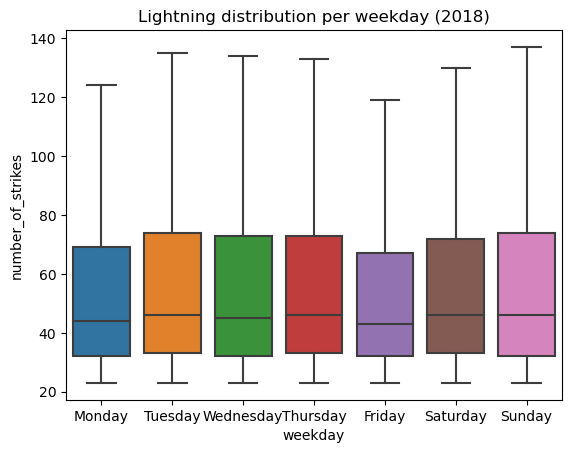

In [45]:
# Create boxplots of strike counts for each day of week.
g = sns.boxplot(data=df, 
            x='weekday',
            y='number_of_strikes', 
            order=weekday_order, 
            showfliers=False 
            );
g.set_title('Lightning distribution per weekday (2018)');

### Monthly lightning strikes 2016, 2018
Finally, we will examine monthly lightning strike data in 2016, and 2018. We will calculate the percentage of total lightning strikes for each year that occurred in a given month. We will then plot this data on a bar graph.

In [49]:
# Import 2016 data
df_2 = pd.read_csv('/Users/timothypark/Documents/portfolios/timpark99.github.io/Lightning Strikes 3/eda_structuring 2.csv')
df_2.head()

,date,number_of_strikes,center_point_geom
0,1/1/16,1,POINT(-80.5 33)
1,1/1/16,1,POINT(-51.6 43.3)
2,1/1/16,1,POINT(-74.5 34.4)
3,1/1/16,1,POINT(-74.6 34.2)
4,1/1/16,1,POINT(-72.2 33.8)


In [55]:
# Convert `date` column to datetime.
df_2['date'] = pd.to_datetime(df_2['date'])

Now we can combine the 2016 dataframe with the 2018 dataframe. There are several functions that can do this. We will use `concat()`. Remember that the 2018 data has two added columns: `week` and `weekday`. To simplify the results of our combined dataframe, we will drop these added columns during the concatenation. Note that the following code doesn't permanently modify `df`. The columns drop only for this operation. You can learn more about the `concat()` function in the [pandas.concat documentation](https://pandas.pydata.org/docs/reference/api/pandas.concat.html).

In [58]:
# ignore_index=True will create one large index shared between the two dataframes
# axis=1 means it is focusing on the column so it will entirely delete both columns
union_df = pd.concat([df.drop(['weekday','week'],axis=1), df_2], ignore_index=True)
union_df.head()

,date,number_of_strikes,center_point_geom
0,2018-01-03,194,POINT(-75 27)
1,2018-01-03,41,POINT(-78.4 29)
2,2018-01-03,33,POINT(-73.9 27)
3,2018-01-03,38,POINT(-73.8 27)
4,2018-01-03,92,POINT(-79 28)


To help us name the bars of the bar plot, we will create three new columns that isolate the year, month number, and month name. 

In [61]:
union_df['year'] = union_df.date.dt.year
union_df['month'] = union_df.date.dt.month
union_df['month_txt'] = union_df.date.dt.month_name()
union_df.head()

,date,number_of_strikes,center_point_geom,year,month,month_txt
0,2018-01-03,194,POINT(-75 27),2018,1,January
1,2018-01-03,41,POINT(-78.4 29),2018,1,January
2,2018-01-03,33,POINT(-73.9 27),2018,1,January
3,2018-01-03,38,POINT(-73.8 27),2018,1,January
4,2018-01-03,92,POINT(-79 28),2018,1,January


Let's check the overall lightning strike count for each year.

In [66]:
union_df[['year','number_of_strikes']].groupby(['year']).sum()

,number_of_strikes
year,
2016,11324747
2018,9936557


Now we will calculate the total number of lightning strikes that occurred in a given month for each year and assign the results to a new dataframe called `lightning_by_month`. 

In [69]:
# Calculate total lightning strikes for each month of each year.
lightning_by_month = union_df.groupby(['month_txt','year']).agg(
    number_of_strikes = pd.NamedAgg(column='number_of_strikes',aggfunc=sum)
    ).reset_index()

lightning_by_month.head()

,month_txt,year,number_of_strikes
0,April,2016,1734153
1,April,2018,832286
2,February,2016,103363
3,February,2018,1739692
4,January,2016,105256


We can use the `agg()` function to calculate the same yearly totals we found before, with 2018 having fewer strikes than 2016

In [76]:
lightning_by_year = union_df.groupby(['year']).agg(
  year_strikes = pd.NamedAgg(column='number_of_strikes',aggfunc=sum)
).reset_index()

lightning_by_year.head()

,year,year_strikes
0,2016,11324747
1,2018,9936557


In our bar plot, we need to use the monthly totals to calculate percentages. For each month, we will need the monthly total strike count and the total strike count for that year. Let's create another dataframe called `percentage_lightning` that adds a new column called `year_strikes` which represents the total number of strikes for each year. We can do this using the `merge()` function. We will merge the `lightning_by_month` dataframe with the `lightning_by_year` dataframe, specifying to merge on the `year` column. This means that wherever the `year` columns contain the same value in both dataframes, a row is created in our new dataframe with all the other columns from both dataframes being merged. To learn more about this function, refer to the [pandas.merge documentation](https://pandas.pydata.org/docs/reference/api/pandas.merge.html).


In [80]:
percentage_lightning = lightning_by_month.merge(lightning_by_year,on='year')
percentage_lightning.head()

,month_txt,year,number_of_strikes,year_strikes
0,April,2016,1734153,11324747
1,February,2016,103363,11324747
2,January,2016,105256,11324747
3,June,2016,4124580,11324747
4,March,2016,1290495,11324747


Now we will create a new column in our new dataframe that represents the percentage of total lightning strikes that occurred during each month for each year. We will do this by dividing the `number_of_strikes` column by the `year_strikes` column and multiplying the result by 100.

In [83]:
percentage_lightning['percentage_lightning_per_month'] = (percentage_lightning.number_of_strikes/
                                                          percentage_lightning.year_strikes * 100.0)
percentage_lightning.head()

,month_txt,year,number_of_strikes,year_strikes,percentage_lightning_per_month
0,April,2016,1734153,11324747,15.312951
1,February,2016,103363,11324747,0.912718
2,January,2016,105256,11324747,0.929434
3,June,2016,4124580,11324747,36.420946
4,March,2016,1290495,11324747,11.395354


Now we can plot the percentages by month in a bar graph.

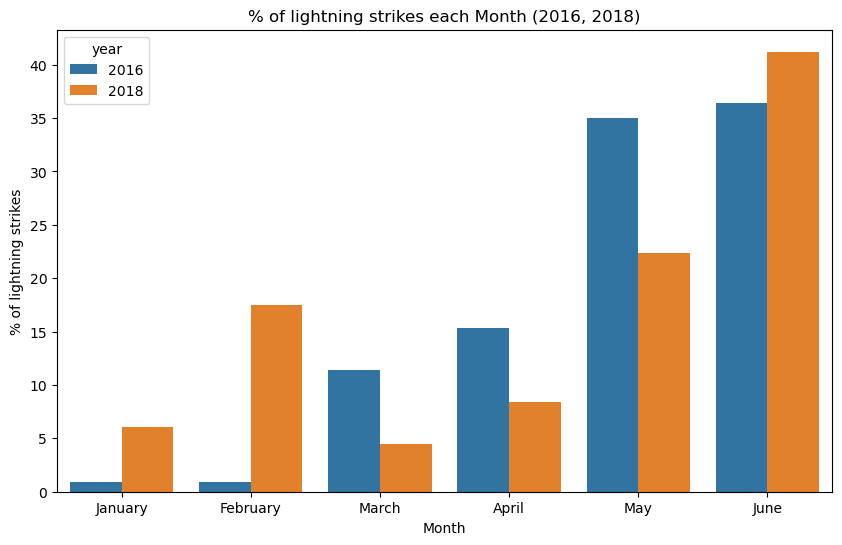

In [88]:
plt.figure(figsize=(10,6));

month_order = ['January', 'February', 'March', 'April', 'May', 'June']

sns.barplot(
    data = percentage_lightning,
    x = 'month_txt',
    y = 'percentage_lightning_per_month',
    hue = 'year',
    order = month_order );
plt.xlabel("Month");
plt.ylabel("% of lightning strikes");
plt.title("% of lightning strikes each Month (2016, 2018)");